In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import psycopg2
import numpy as np
import pandas as pd
import polars as pl
from venn import venn
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT"))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DATA_FOLDER = os.getenv("DATA_FOLDER")

In [3]:
bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

In [4]:
if "events.csv" not in os.listdir(DATA_FOLDER):
    with bigbrotr.cursor() as cur:
        with open(os.path.join(DATA_FOLDER, 'events.csv'), 'w') as f:
            # Usa COPY per esportare i dati in CSV
            cur.copy_expert("COPY (SELECT id, pubkey, created_at, kind FROM events) TO STDOUT WITH CSV HEADER", f)
events = pl.read_csv(os.path.join(DATA_FOLDER, 'events.csv'))

In [5]:
# numero totale di eventi e numero totale di pubkey
total_events = events.shape[0]
total_pubkeys = events['pubkey'].n_unique()
print(f"Numero totale di eventi: {total_events}")
print(f"Numero totale di pubkey: {total_pubkeys}")

Numero totale di eventi: 172664903
Numero totale di pubkey: 19681031


In [6]:
kind_counts = events.select(
    pl.col("kind").value_counts()
)
kind_counts = pd.DataFrame(kind_counts.to_pandas())
kind_counts['count'] = kind_counts['kind'].apply(lambda x: x['count'])
kind_counts['kind'] = kind_counts['kind'].apply(lambda x: x['kind'])
kind_counts = kind_counts.sort_values('count', ascending=False).reset_index(drop=True)
kind_counts['perc'] = kind_counts['count'] / kind_counts['count'].sum() * 100

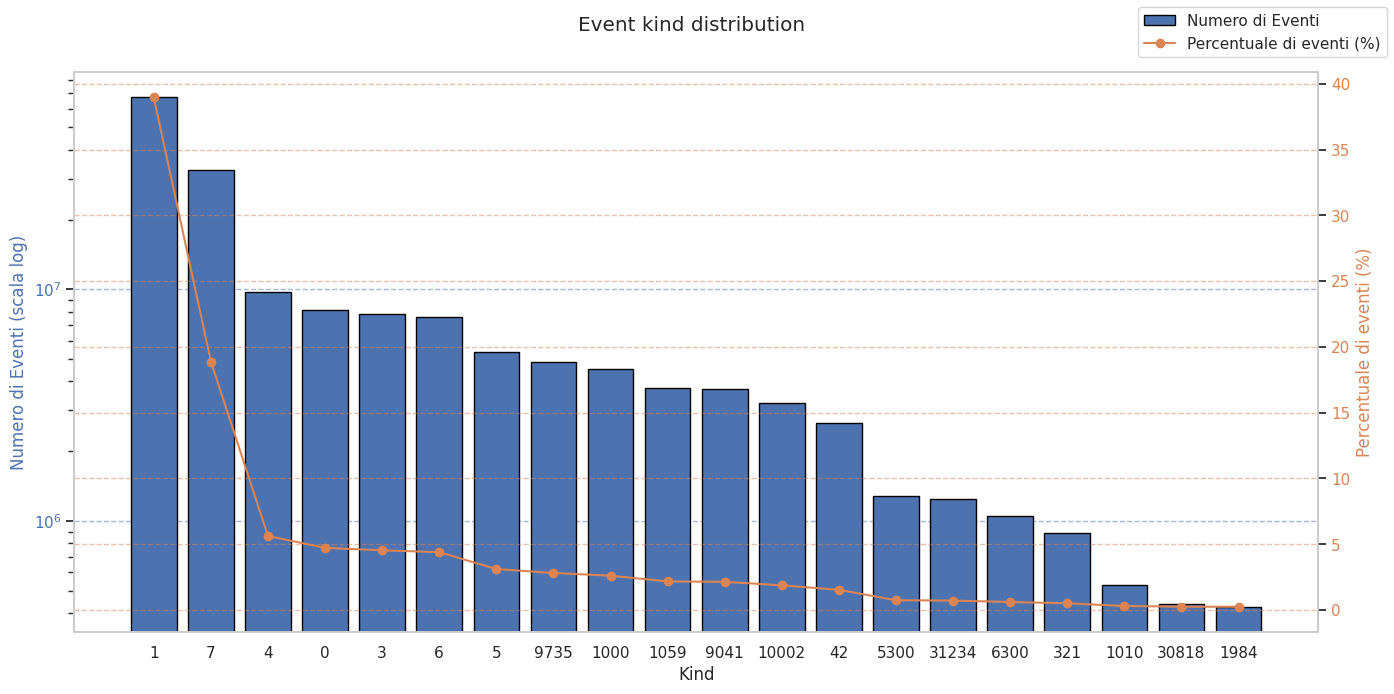

In [7]:
# Selezione dei primi 20 valori
df_plot = kind_counts.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Eventi', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Eventi (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # Rendi trasparente lo sfondo per non coprire le barre

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di eventi (%)', zorder=3)
ax2.set_ylabel('Percentuale di eventi (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind distribution')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [8]:
kind_share = events.unique(subset=["kind", "pubkey"])
kind_share = kind_share.select(
    pl.col("kind").value_counts()
)
kind_share = pd.DataFrame(kind_share.to_pandas())
kind_share['count'] = kind_share['kind'].apply(lambda x: x['count'])
kind_share['kind'] = kind_share['kind'].apply(lambda x: x['kind'])
kind_share = kind_share.sort_values('count', ascending=False).reset_index(drop=True)
kind_share['perc'] = kind_share['count'] / kind_share['count'].sum() * 100

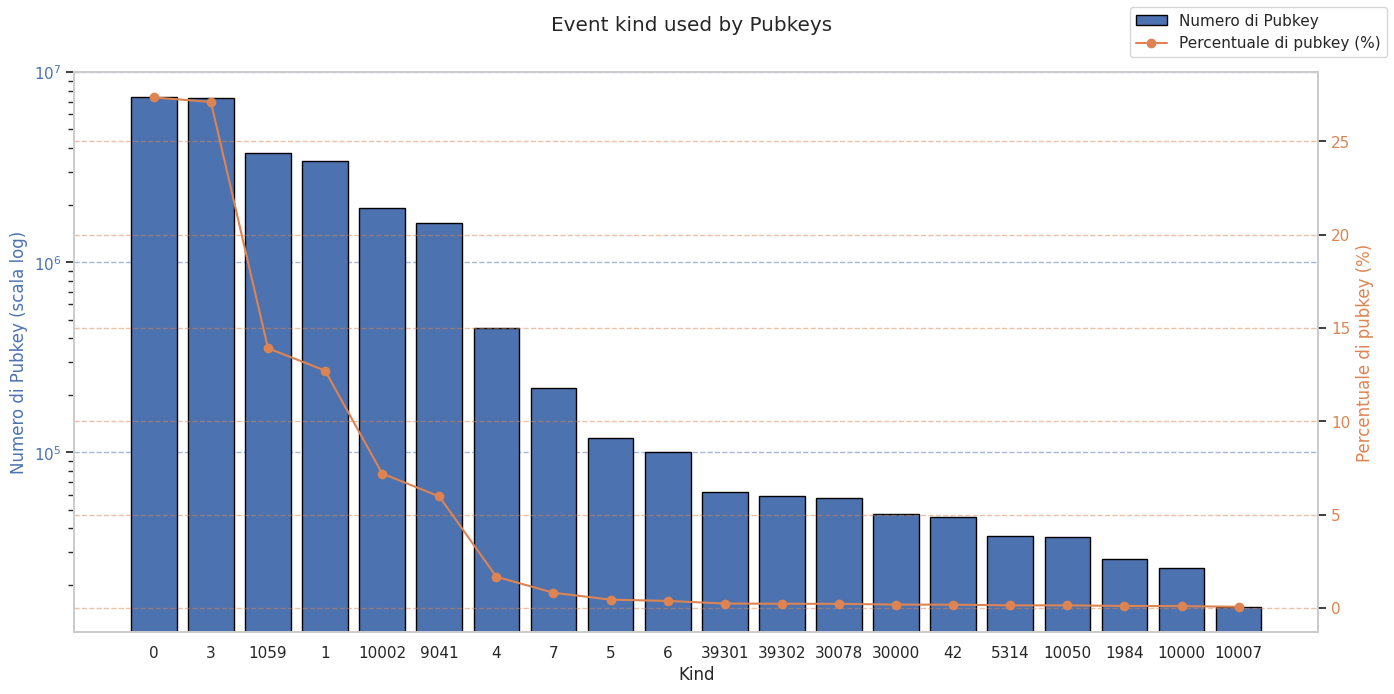

In [9]:
# Selezione dei primi 20 valori
df_plot = kind_share.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Pubkey', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Pubkey (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # sfondo trasparente

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di pubkey (%)', zorder=3)
ax2.set_ylabel('Percentuale di pubkey (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind used by Pubkeys')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [10]:
merged = kind_share.merge(kind_counts, on='kind', suffixes=('_pubkey', '_event'))

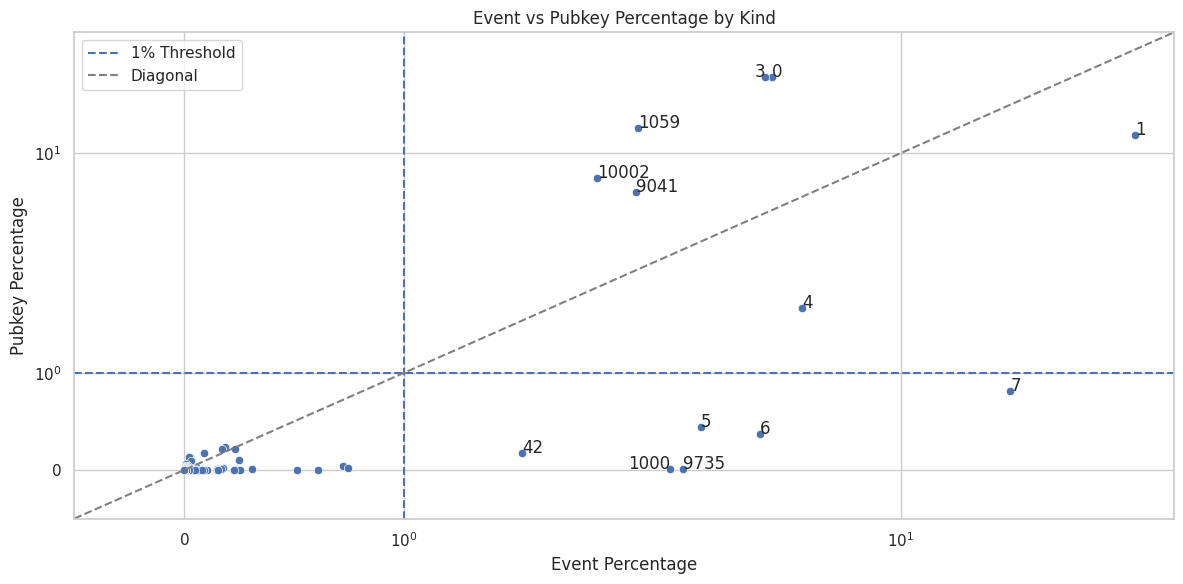

In [11]:
plt.figure()

sns.scatterplot(
    data=merged,
    x='perc_event',
    y='perc_pubkey',
)

plt.xlabel('Event Percentage')
plt.ylabel('Pubkey Percentage')
plt.title('Event vs Pubkey Percentage by Kind')
plt.xscale('symlog')
plt.yscale('symlog')
plt.tight_layout()

min_val = min(merged['perc_event'].min(), merged['perc_pubkey'].min())
max_val = max(merged['perc_event'].max(), merged['perc_pubkey'].max())

# Imposta gli stessi limiti per entrambi gli assi
plt.xlim(min_val-0.5, max_val+10)
plt.ylim(min_val-0.5, max_val+10)

# add label per ogni punto solo se il valore è maggiore di 0.1
for i in range(len(merged)):
    if merged['perc_event'].iloc[i] >= 1 or merged['perc_pubkey'].iloc[i] >= 1:
        if merged['kind'].iloc[i] not in [3, 1000]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='left',
                va='baseline',
            )
        else:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='right',
                va='baseline',
            )
plt.axhline(y=1, linestyle='--', label='1% Threshold')
plt.axvline(x=1, linestyle='--')
# plot bisettrice line
plt.plot([min_val-0.5, max_val+10], [min_val-0.5, max_val+10], linestyle='--', color='gray', label='Diagonal')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
kinds_info = pd.read_csv(os.path.join(DATA_FOLDER, 'kinds_info.csv'))
relevant_kinds = merged[(merged['perc_event'] >= 1) | (merged['perc_pubkey'] >= 1)].filter(['kind'])
relevant_kinds = relevant_kinds.merge(kinds_info, on='kind', how='left')
relevant_kinds

,kind,title,linked_code,file_name,status
0,0,User Metadata,01,01.md,NaN
1,3,Follows,02,02.md,NaN
2,1059,Gift Wrap,59,59.md,NaN
3,1,Short Text Note,10,10.md,NaN
4,10002,Relay List Metadata,65,65.md,NaN
5,9041,Zap Goal,75,75.md,NaN
6,4,Encrypted Direct Messages,04,04.md,NaN
7,7,Reaction,25,25.md,NaN
8,5,Event Deletion Request,09,09.md,NaN
9,6,Repost,18,18.md,NaN


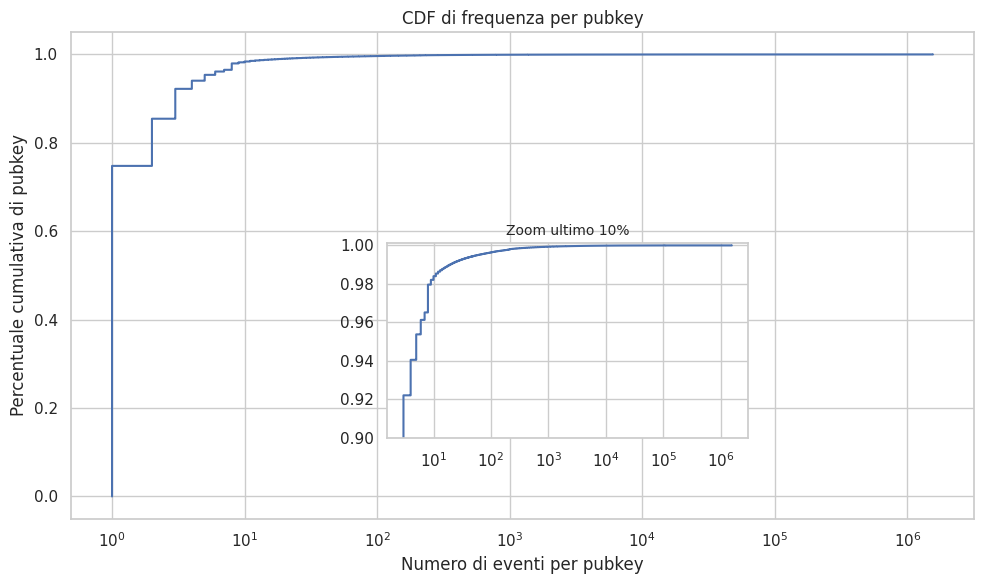

In [13]:
# Calcolo frequenze
pubkey_counts = (
    events
    .group_by(["pubkey"])
    .agg(pl.count().alias("num_events"))
)

freq = pubkey_counts["num_events"].to_list()
freq_sorted = np.sort(freq)
cdf = np.arange(1, len(freq_sorted) + 1) / len(freq_sorted)

# Grafico principale
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(freq_sorted, cdf, where='post', label='CDF di frequenza per pubkey')
ax.set_xlabel('Numero di eventi per pubkey')
ax.set_ylabel('Percentuale cumulativa di pubkey')
ax.set_title('CDF di frequenza per pubkey')
ax.set_xscale('log')
ax.grid(True)

# Zoom: filtro con CDF >= 0.9
mask = cdf >= 0.9
freq_zoom = freq_sorted[mask]
cdf_zoom = cdf[mask]

# Sottografo (inset)
ax_inset = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc='lower center',
        bbox_to_anchor=(0.05, 0.15, 1, 1),  # (x0, y0, width, height) relative to ax
        bbox_transform=ax.transAxes
    )
ax_inset.step(freq_zoom, cdf_zoom, where='post')
ax_inset.set_xscale('log')
ax_inset.set_ylim(0.9, 1.001)
ax_inset.set_title('Zoom ultimo 10%', fontsize=10)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Conta quante volte appare ogni pubkey
counts = events.group_by("pubkey").agg([
    pl.count().alias("num_events")
])

# Filtra solo le pubkey che appaiono una volta
single_use_pubkeys = counts.filter(
    pl.col("num_events") == 1
).select("pubkey")

# Fai un inner join per mantenere solo gli eventi di quelle pubkey
filtered_events = events.join(single_use_pubkeys, on="pubkey", how="inner")

kind_stats = filtered_events.group_by("kind").agg([
    pl.count().alias("count")
]).sort("count", descending=True)

# Calcola la percentuale
total = kind_stats["count"].sum()
kind_stats = kind_stats.with_columns([
    (pl.col("count") / total * 100).alias("percentage")
])
print("Statistiche per kind di eventi con pubkey che appaiono una sola volta:")
display(kind_stats.head(10))

# fai la stessa cosa ma per il top 1% delle pubkey che pubblicano piu'; eventi in assoluto
top_1_percent_pubkeys = (
    events.group_by("pubkey")
    .agg(pl.count().alias("num_events"))
    .sort("num_events", descending=True)
    .head(int(0.01 * events["pubkey"].n_unique()))
    .select("pubkey")
)

# Fai un inner join per mantenere solo gli eventi di quelle pubkey
filtered_events_top_1 = events.join(top_1_percent_pubkeys, on="pubkey", how="inner")
kind_stats_top_1 = filtered_events_top_1.group_by("kind").agg([
    pl.count().alias("count")
]).sort("count", descending=True)   

# Calcola la percentuale
total_top_1 = kind_stats_top_1["count"].sum()
kind_stats_top_1 = kind_stats_top_1.with_columns([
    (pl.col("count") / total_top_1 * 100).alias("percentage")
])
print("Statistiche per kind di eventi con pubkey che appartengono al top 1% per numero di eventi:")
display(kind_stats_top_1.head(10))

Statistiche per kind di eventi con pubkey che appaiono una sola volta:


kind,count,percentage
i64,u32,f64
3,5424600,36.856409
0,4318903,29.343962
1059,3748147,25.466069
1,691000,4.694868
4,212725,1.445319
10002,143065,0.972028
5,36291,0.246572
5314,36127,0.245458
9041,28134,0.191151


Statistiche per kind di eventi con pubkey che appartengono al top 1% per numero di eventi:


kind,count,percentage
i64,u32,f64
1,62168311,44.136122
7,32301617,22.932393
4,9089335,6.452934
6,7517237,5.33683
5,5266649,3.739035
9735,4854019,3.44609
1000,4499403,3.194332
42,2568060,1.823183
5300,1279588,0.908438


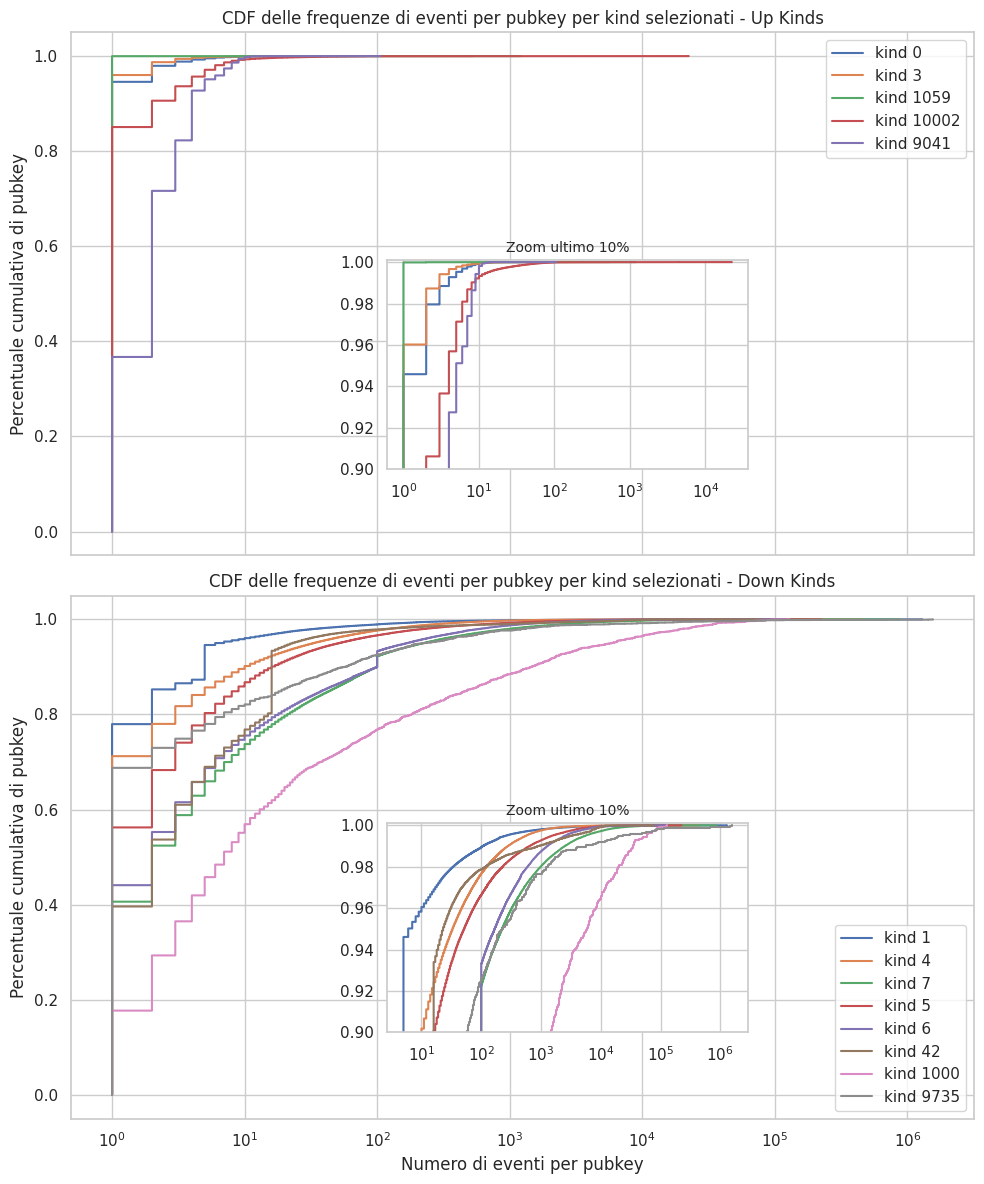

In [15]:
selected_kinds = relevant_kinds["kind"].to_list()

# Filtra eventi per i kind selezionati
events_filtered = events.filter(pl.col("kind").is_in(selected_kinds))

# Raggruppa per pubkey e kind e conta numero di eventi
pubkey_kind_counts = (
    events_filtered
    .group_by(["pubkey", "kind"])
    .agg(pl.count().alias("num_events"))
)

up_kinds = merged[(merged["perc_event"] < merged["perc_pubkey"]) & ((merged['perc_event'] >= 1) | (merged['perc_pubkey'] >= 1))]['kind'].to_list()
down_kinds = merged[(merged["perc_event"] >= merged["perc_pubkey"]) & ((merged['perc_event'] >= 1) | (merged['perc_pubkey'] >= 1))]['kind'].to_list()

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for ax, kinds, title in zip(axes, [up_kinds, down_kinds], ['Up Kinds', 'Down Kinds']):
    # Crea inset una sola volta per subplot, in basso a destra
    ax_inset = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc='lower center',
        bbox_to_anchor=(0.05, 0.15, 1, 1),  # (x0, y0, width, height) relative to ax
        bbox_transform=ax.transAxes
    )

    for kind in kinds:
        filtered = pubkey_kind_counts.filter(pl.col("kind") == kind)
        freq = filtered["num_events"].to_list()
        if len(freq) == 0:
            continue
        freq_sorted = np.sort(freq)
        cdf = np.arange(1, len(freq_sorted) + 1) / len(freq_sorted)

        # Plot CDF completa nel subplot principale
        ax.step(freq_sorted, cdf, where='post', label=f"kind {kind}")

        # Plot CDF zoomata nell'inset (ultimo 10%)
        mask = cdf >= 0.9
        freq_zoom = freq_sorted[mask]
        cdf_zoom = cdf[mask]
        ax_inset.step(freq_zoom, cdf_zoom, where='post', label=f"kind {kind}")

    ax.set_ylabel("Percentuale cumulativa di pubkey")
    ax.set_title(f"CDF delle frequenze di eventi per pubkey per kind selezionati - {title}")
    ax.grid(True)
    ax.legend()

    # Configura inset
    ax_inset.set_xscale('log')
    ax_inset.set_ylim(0.9, 1.001)
    ax_inset.set_title("Zoom ultimo 10%", fontsize=10)
    ax_inset.grid(True)

axes[-1].set_xlabel("Numero di eventi per pubkey")
axes[-1].set_xscale('log')

plt.tight_layout()
plt.show()

In [16]:
def foo(sets):
    all_keys = list(sets.keys())
    total_pubkeys = len(set.union(*sets.values()))
    intersections = {}
    for i in range(1, len(all_keys)+1):
        for combo in combinations(all_keys, i):
            intersect = set.intersection(*[sets[k] for k in combo])
            intersections[combo] = {
                "count": len(intersect),
                "perc": (len(intersect) / total_pubkeys * 100) if total_pubkeys > 0 else 0
            }
    rows = []
    for combo, stats in intersections.items():
        rows.append({
            "kind_combination": ", ".join(combo),
            "count": stats["count"],
            "perc": stats["perc"]
        })
    intersections_df = pd.DataFrame(rows)
    # Ordina per numero di pubkey
    intersections_df = intersections_df.sort_values(by='count', ascending=False).reset_index(drop=True)
    return intersections_df

Total unique pubkeys: 19681031
Unique pubkeys in kinds 0, 3, 1, 6, 7: 15268930 (77.58%)


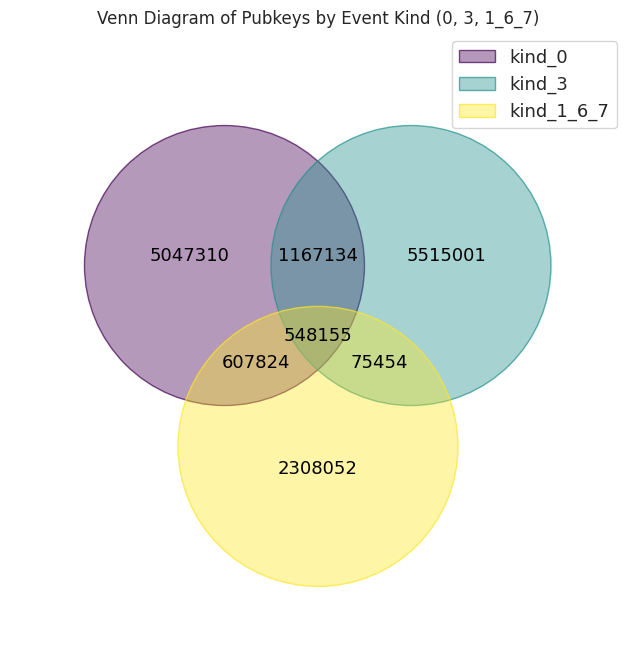

,kind_combination,count,perc
0,kind_0,7370423,48.270724
1,kind_3,7305744,47.847125
2,kind_1_6_7,3539485,23.180963
3,"kind_0, kind_3",1715289,11.233852
4,"kind_0, kind_1_6_7",1155979,7.570792
5,"kind_3, kind_1_6_7",623609,4.084170
6,"kind_0, kind_3, kind_1_6_7",548155,3.590003


In [17]:
# Crea i set per ciascun tipo di evento
kind_0 = set(events.filter(pl.col("kind") == 0).select("pubkey").to_series().to_list())
kind_3 = set(events.filter(pl.col("kind") == 3).select("pubkey").to_series().to_list())
kind_1_6_7 = set(events.filter(pl.col("kind").is_in([1, 6, 7])).select("pubkey").to_series().to_list())

kind_sets = {
    "kind_0": kind_0,
    "kind_3": kind_3,
    "kind_1_6_7": kind_1_6_7
}

all_pubkeys_count = events.select(
    pl.col("pubkey").n_unique()
).to_series().item()
all_kind_pubkeys_count = events.filter(
    pl.col("kind").is_in([0, 3, 1, 6, 7])
).select(
    pl.col("pubkey").n_unique()
).to_series().item()
print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 0, 3, 1, 6, 7: {all_kind_pubkeys_count} ({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")

# --- Step 2: Plotta il diagramma di Venn per i 4 insiemi ---
venn(kind_sets)
plt.title("Venn Diagram of Pubkeys by Event Kind (0, 3, 1_6_7)")
plt.show()

foo(kind_sets)

Total unique pubkeys: 19681031
Unique pubkeys in kinds 1, 6, 7: 3539485 (17.98%)


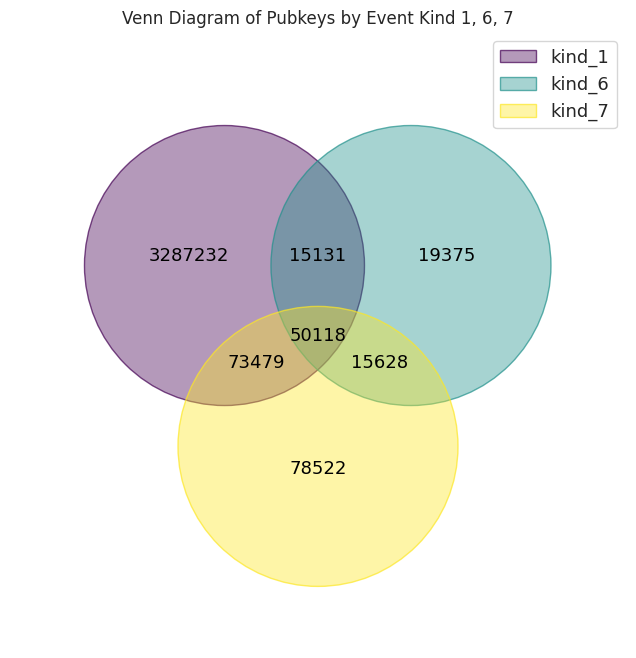

,kind_combination,count,perc
0,kind_1,3425960,96.792612
1,kind_7,217747,6.151940
2,"kind_1, kind_7",123597,3.491949
3,kind_6,100252,2.832389
4,"kind_6, kind_7",65746,1.857502
5,"kind_1, kind_6",65249,1.843460
6,"kind_1, kind_6, kind_7",50118,1.415969


In [18]:
# Crea i set per kind 1, 6, 7
kind_1 = set(events.filter(pl.col("kind") == 1).select("pubkey").to_series().to_list())
kind_6 = set(events.filter(pl.col("kind") == 6).select("pubkey").to_series().to_list())
kind_7 = set(events.filter(pl.col("kind") == 7).select("pubkey").to_series().to_list())

# Dizionario dei set
sets = {
    "kind_1": kind_1,
    "kind_6": kind_6,
    "kind_7": kind_7
}

all_pubkeys_count = events.select(
    pl.col("pubkey").n_unique()
).to_series().item()
all_kind_pubkeys_count = events.filter(
    pl.col("kind").is_in([1, 6, 7])
).select(
    pl.col("pubkey").n_unique()
).to_series().item()
print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 1, 6, 7: {all_kind_pubkeys_count} ({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")


# Genera il diagramma di Venn
venn(sets)
plt.title("Venn Diagram of Pubkeys by Event Kind 1, 6, 7")
plt.show()

foo(sets)

In [19]:
#add col in events ad day from created_at as a second time series
events = events.with_columns([
    (pl.col("created_at") * 1000).cast(pl.Datetime("ms")).dt.date().alias("day")
])

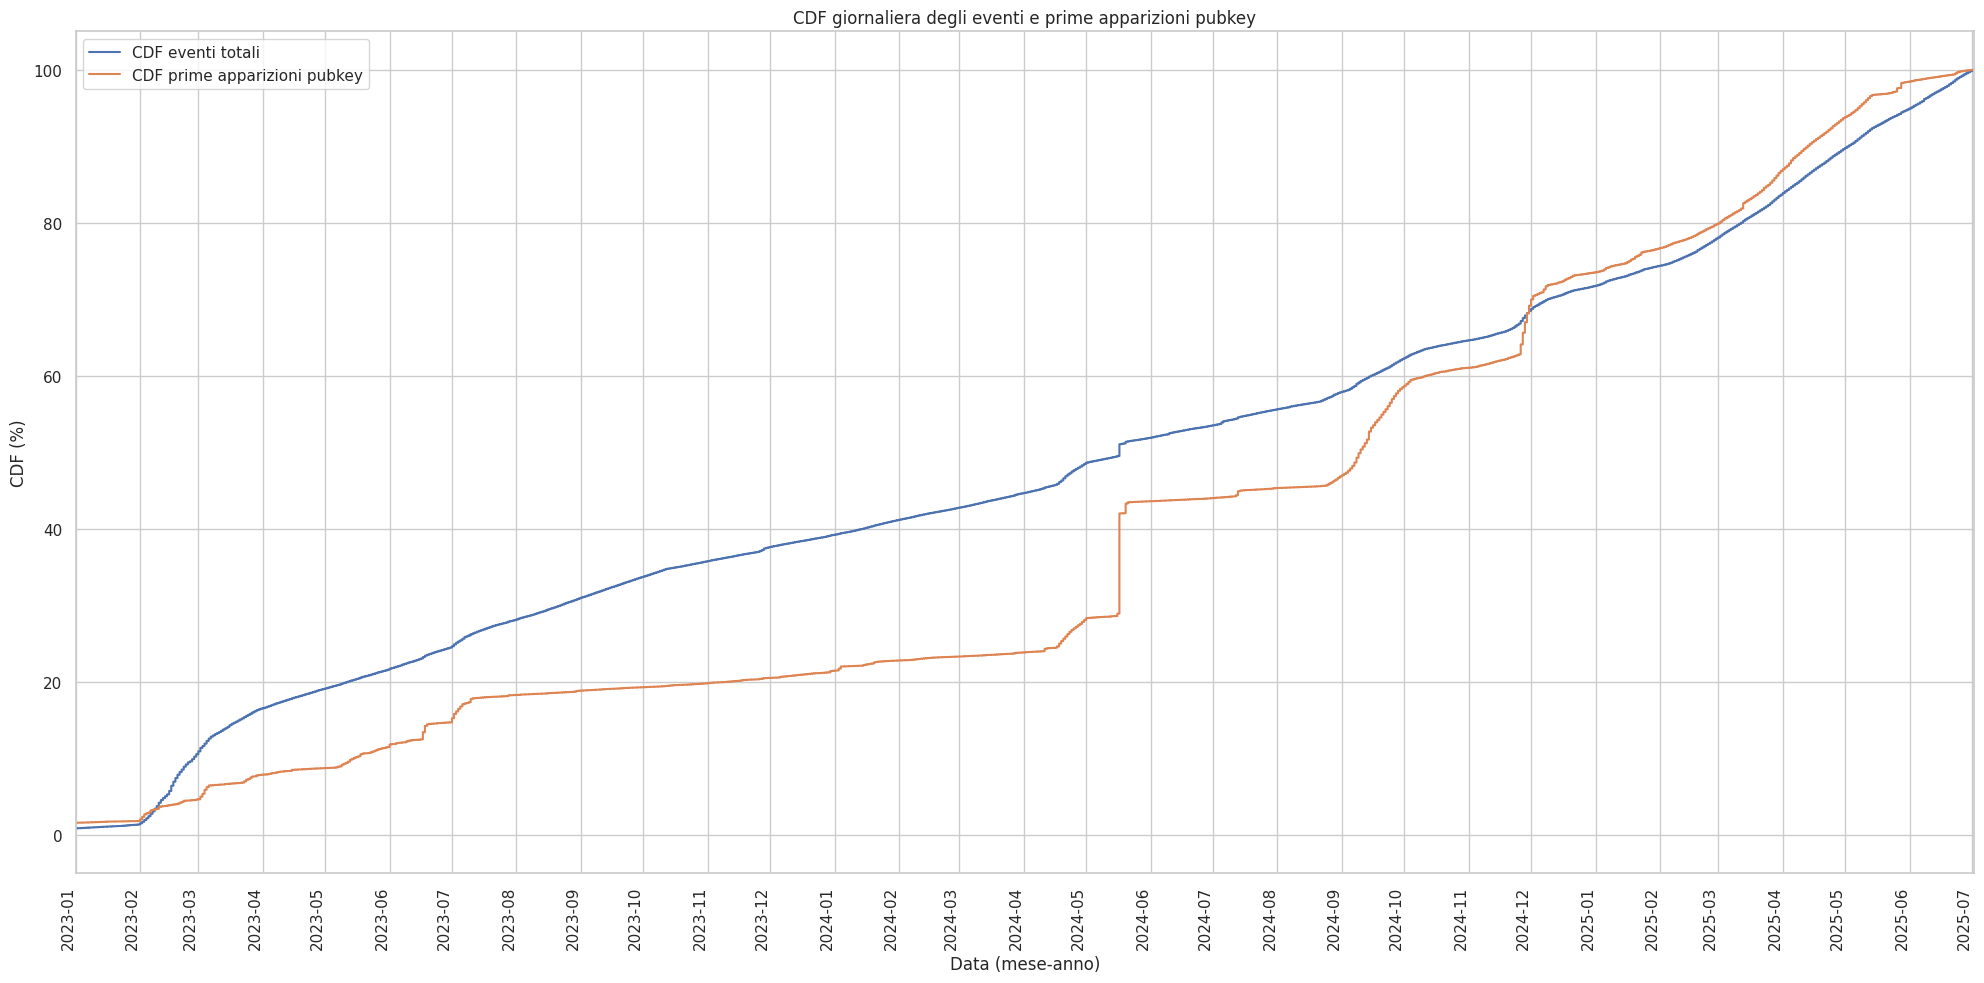

In [65]:
# Raggruppa per giorno (tutti gli eventi)
daily = events.group_by("day").agg([
    pl.count().alias("count")
]).sort("day")

# Calcola cumulata e CDF in percentuale per tutti gli eventi
total = daily["count"].sum()
cdf_df = daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count")
])
cdf_df = cdf_df.with_columns([
    (pl.col("cum_count") / total * 100).alias("cdf")
])

# --- Ora estraiamo il primo evento per ogni pubkey ---
first_events = events.group_by("pubkey").agg([
    pl.min("created_at").alias("first_created_at")
])

# Estrai solo la data del primo evento per pubkey
first_events = first_events.with_columns([
    (pl.col("first_created_at")* 1000).cast(pl.Datetime("ms")).dt.date().alias("first_day")
])

# Raggruppa per giorno (prime apparizioni)
first_daily = first_events.group_by("first_day").agg([
    pl.count().alias("count")
]).sort("first_day")

# Calcola cumulata e CDF prime apparizioni pubkey
total_first = first_daily["count"].sum()
cdf_first_df = first_daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count")
])
cdf_first_df = cdf_first_df.with_columns([
    (pl.col("cum_count") / total_first * 100).alias("cdf")
])

# Prepara dati per matplotlib
days = pd.to_datetime(cdf_df["day"].to_pandas())
cdf_values = cdf_df["cdf"].to_numpy()

first_days = pd.to_datetime(cdf_first_df["first_day"].to_pandas())
cdf_first_values = cdf_first_df["cdf"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(days, cdf_values, drawstyle="steps-post", label="CDF eventi totali")
ax.plot(first_days, cdf_first_values, drawstyle="steps-post", label="CDF prime apparizioni pubkey")

ax.set_title("CDF giornaliera degli eventi e prime apparizioni pubkey")
ax.set_xlabel("Data (mese-anno)")
ax.set_ylabel("CDF (%)")
ax.set_xlim(pd.to_datetime("2023-01-01"), max(days.max(), first_days.max()))

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=90)

ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

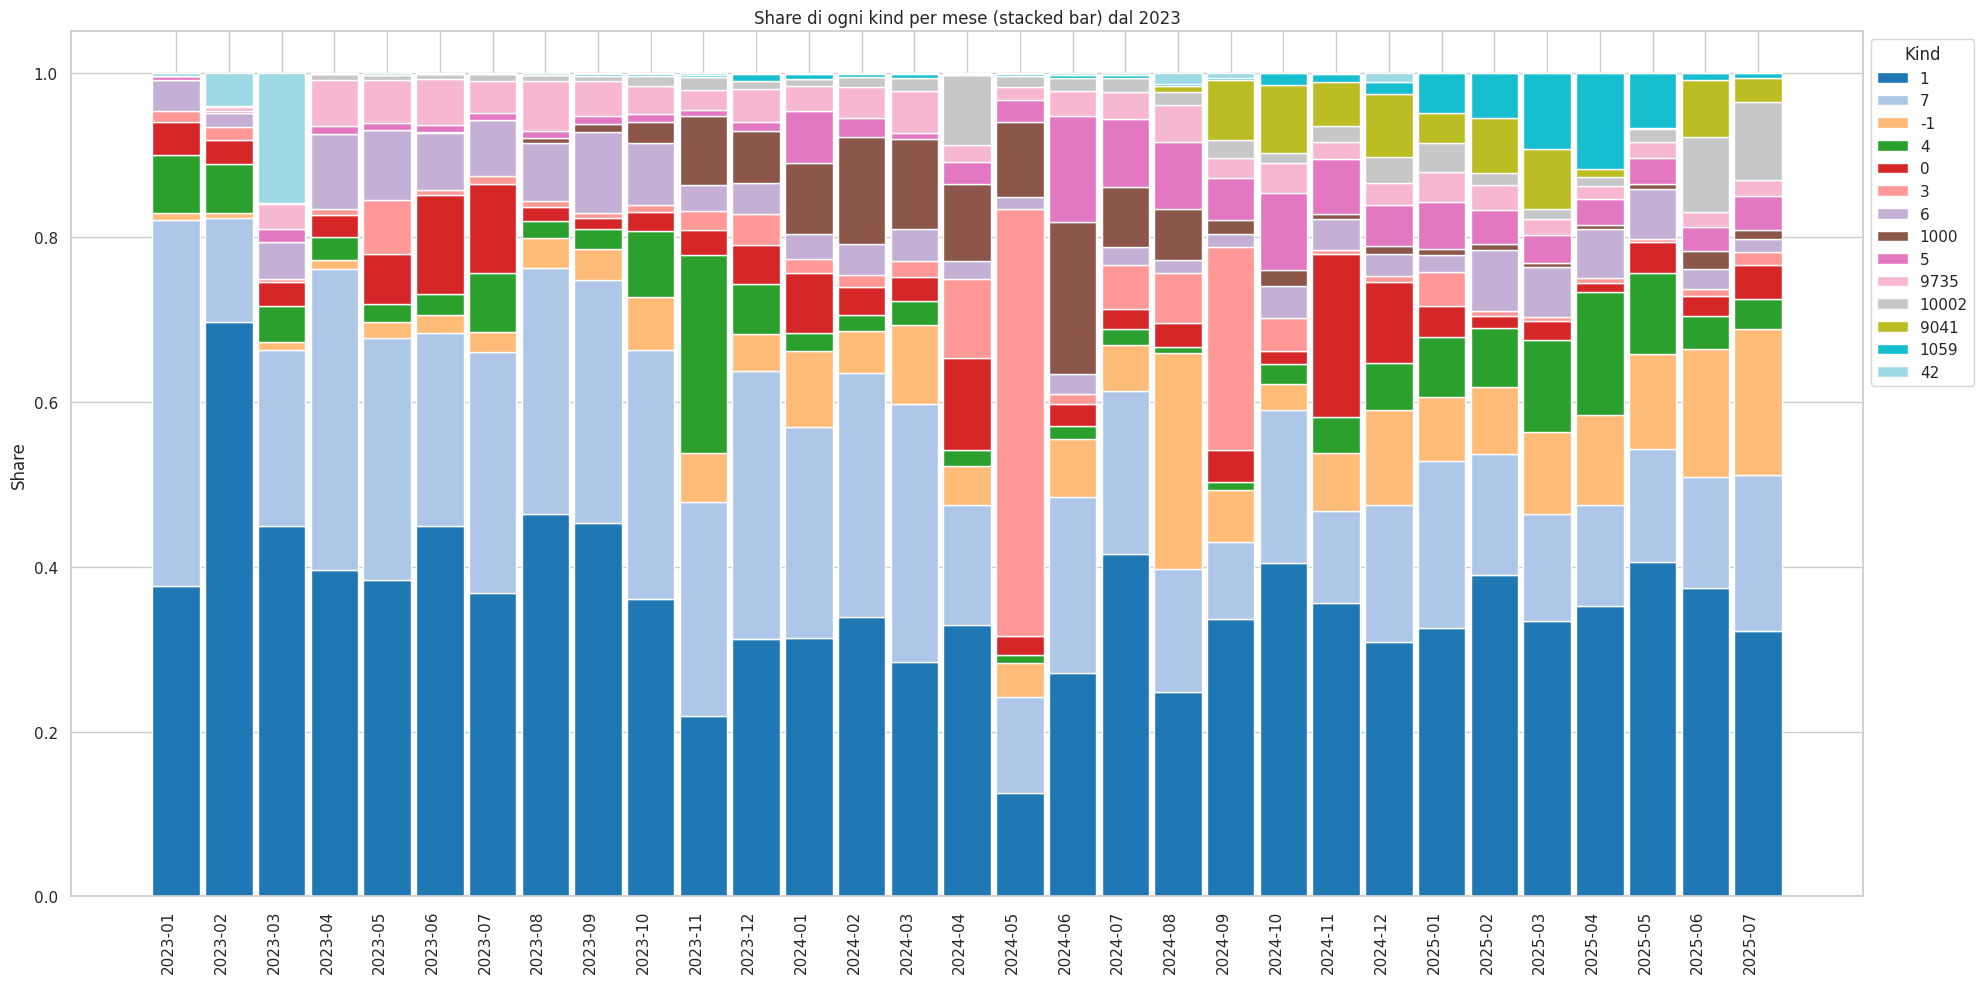

In [67]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from datetime import date

# Lista dei kind rilevanti
relevant_kind_list = relevant_kinds["kind"].to_list()

# Sostituisci i kind non rilevanti con -1
events = events.with_columns([
    pl.when(pl.col("kind").is_in(relevant_kind_list))
      .then(pl.col("kind"))
      .otherwise(-1)
      .alias("kind")
])

# Estrai mese (primo giorno del mese)
events = events.with_columns([
    pl.col("day").dt.truncate("1mo").alias("month")
])

# Conta eventi per mese e kind
count_df = events.group_by(["month", "kind"]).agg(
    pl.count().alias("count_kind")
)

# Conta eventi totali per mese
total_df = events.group_by("month").agg(
    pl.count().alias("total_month")
)

# Unione conteggi
joined = count_df.join(total_df, on="month")

# Calcola share
result = joined.with_columns(
    (pl.col("count_kind") / pl.col("total_month")).alias("share")
)

# Pivot: mesi come righe, kind come colonne
pivot = result.pivot(
    values="share",
    index="month",
    columns="kind"
).fill_null(0).sort("month")

# Converti mesi in datetime.date (già probabilmente lo sono)
months_dates = pivot["month"].to_list()

# Filtra mesi dal 2023-01 in poi usando datetime.date
filter_date = date(2023, 1, 1)
mask = [m >= filter_date for m in months_dates]
filtered_months_dt = [m for m, keep in zip(months_dates, mask) if keep]
filtered_months_str = [m.strftime("%Y-%m") for m in filtered_months_dt]

# Filtra pivot per mesi dal 2023
filtered_pivot = pivot.filter(pl.col("month") >= filter_date)

# Prendi i kind (colonne) esclusa la colonna 'month'
kinds = [col for col in filtered_pivot.columns if col != "month"]

# Ordina i kind per somma decrescente degli share totali
kinds_sorted = sorted(
    kinds,
    key=lambda k: filtered_pivot[k].sum(),
    reverse=True
)

# Prepara dati ordinate per stacked bar
filtered_data = {kind: filtered_pivot[kind].to_list() for kind in kinds_sorted}

# Genera colormap distinta
num_kinds = len(kinds_sorted)
cmap = cm.get_cmap("tab20", num_kinds)
colors = [cmap(i) for i in range(num_kinds)]

fig, ax = plt.subplots(figsize=(20, 10))

bottom = np.zeros(len(filtered_months_str))
bar_width = 0.9  # Barre larghe 0.9 per ridurre spazi tra barre (max 1.0)

for i, kind in enumerate(kinds_sorted):
    shares = filtered_data[kind]
    ax.bar(filtered_months_str, shares, bottom=bottom, label=str(kind), color=colors[i], width=bar_width)
    bottom += np.array(shares)

ax.set_ylabel("Share")
ax.set_title("Share di ogni kind per mese (stacked bar) dal 2023")
ax.legend(title="Kind", loc="upper left", bbox_to_anchor=(1, 1))
fig.autofmt_xdate(rotation=90)

plt.tight_layout()
plt.show()

In [22]:
# bigbrotr.close()